In [1]:
import numpy as np
import scipy.stats as sps
import requests
import networkx as nx
import time
import scipy.spatial as spt
import collections
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from tqdm import tqdm_notebook
%matplotlib inline

---
# Загрузка графа друзей вк

In [2]:
import urllib, json, sys

In [50]:
def get_data(token, uid):
    url  = u'https://api.vk.com/method/friends.get?v=5.21&fields=sex,city,education&user_id=%s&lang=en&access_token=%s' %(uid ,token)

    res  = urllib.request.urlopen(url).read()
    data = json.loads(res)
    ids = [item['id'] for item in data['response']['items']]
    names = {item['id']: item['first_name'] + ' ' + item['last_name'] for item in data['response']['items']}
    info = {item['id']: {'city': item['city']['title'] if 'city' in item else '', 
             'university' : item['university_name'] if 'university_name' in item else '', 'sex' : item['sex'] if 'sex' in item else None} 
            for item in data['response']['items']}
    return (ids, names, info)

In [65]:
token = '6608385f2273560a25912c0177a1c422e2a44b4017d22876f1c9d5dd487e1b45d6d849579ff964b8225b1'

uid = '79890568'

ids, names, info = get_data(token, uid)

G = nx.Graph()
G.add_nodes_from(ids)

for attr in ['city', 'university', 'sex']:
    attr_arr = {}
    for idx in ids:
        attr_arr[idx] = info[idx][attr]
    nx.set_node_attributes(G, attr_arr, attr)

In [67]:
for i in tqdm_notebook(ids):
    i_ids, _, _ = get_data(token, i)
    time.sleep(0.5)
    intersection = set.intersection(set(ids), set(i_ids))
    for j in intersection:
        G.add_edge(i, j)

---
# Анализ графа

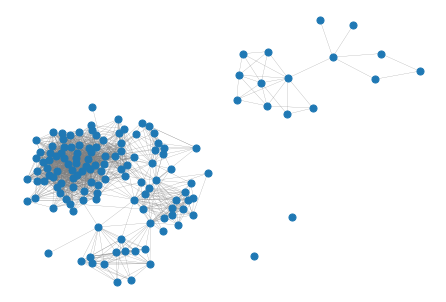

In [6]:
fig = plt.figure()
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw(G, pos, node_size=50, edge_color='grey', with_labels=False, width=0.2)
plt.savefig('graph.pdf', dpi=plt.gcf().dpi)
plt.show()

In [7]:
print("Число вершин: {}".format(len(G)))
print("Число ребер: {}".format(len(G.edges())))

for nodes in nx.connected_components(G):
    nodes = list(nodes)
    if len(nodes) > 80:
        G_prime = G.subgraph(nodes)
        print("Диаметр максимальной компоненты: {}".format(nx.diameter(G_prime)))
    elif len(nodes) > 3:
        G_prime = G.subgraph(nodes)
        print("Диаметр минимальной компоненты: {}".format(nx.diameter(G_prime)))
        
n = len(G)
triangles = sum(list(nx.algorithms.cluster.triangles(G).values())) / 3
print("Коэффициент кластеризации: {}".format(round(np.mean(list(nx.clustering(G).values())), 2)))

Число вершин: 138
Число ребер: 1556
Диаметр максимальной компоненты: 5
Диаметр минимальной компоненты: 4
Коэффициент кластеризации: 0.62


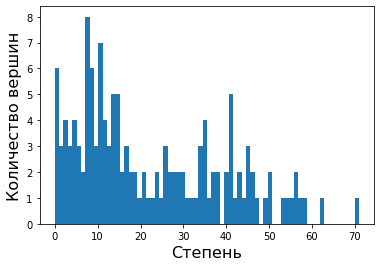

In [9]:
degrees = np.asarray([val for (node, val) in G.degree()])
_, _, _ = plt.hist(degrees, bins=70)
plt.xlabel('Степень', fontsize=16)
plt.ylabel('Количество вершин', fontsize=16)
plt.savefig('degree.pdf')
plt.show()

---
# Structural Analysis

## Centralities
---

### Degree centralities

In [10]:
dc = nx.degree_centrality(G)
top_degree_centralities = sorted(list(dc.items()), key=lambda x: -x[1])
top_degree_centralities_ids = [names[c[0]] for c in top_degree_centralities[:5]]

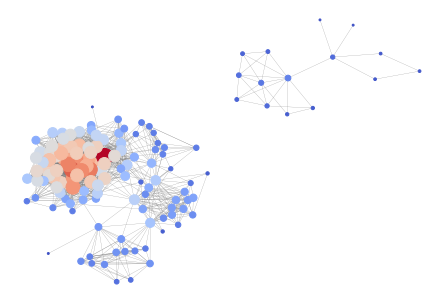

In [11]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
values = np.asarray(list(dc.values())) * 500
low, *_, high = sorted(values)
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
nx.draw(G, pos, nodelist=ids, edge_color='grey', node_size=values, 
        node_color=[mapper.to_rgba(i) for i in values], 
        with_labels=False, width=0.2)
plt.savefig('degree_centralities.pdf')
plt.show()

In [12]:
top_degree_centralities_ids

['Alexander Grishutin',
 'Malik Gazizullin',
 'Ilya Gridasov',
 'Evgeny Gostkin',
 'Vyacheslav Ivanov']

---
Все являются моими однокурсниками.

---
### Closeness centralities

In [13]:
cc = nx.closeness_centrality(G)
top_closeness_centralities = sorted(list(cc.items()), key=lambda x: -x[1])
top_closeness_centralities_ids = [names[c[0]] for c in top_closeness_centralities[:5]]

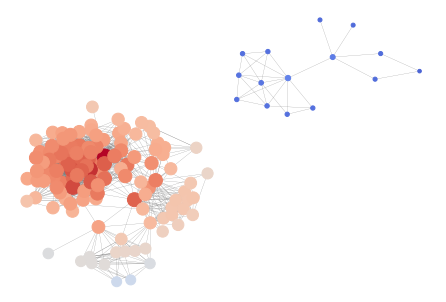

In [14]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
values = np.asarray(list(cc.values())) * 400
low, *_, high = sorted(values)
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
nx.draw(G, pos, nodelist=ids, edge_color='grey', node_size=values, 
        node_color=[mapper.to_rgba(i) for i in values], 
        with_labels=False, width=0.2)
plt.savefig('closeness_centralities.pdf')
plt.show()

In [15]:
top_closeness_centralities_ids

['Alexander Grishutin',
 'Ilya Gridasov',
 'Zaur Datkhuzhev',
 'Malik Gazizullin',
 'Alexey Kozinov']

---
Опять же, все являются моими однокурсниками.

---
### Betweenness centrlities

In [16]:
bc = nx.betweenness_centrality(G)
top_betweenness_centralities = sorted(list(bc.items()), key=lambda x: -x[1])
top_betweenness_centralities_ids = [names[c[0]] for c in top_betweenness_centralities[:5]]

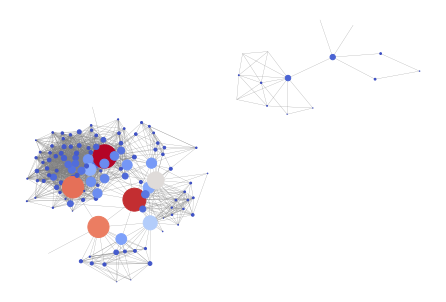

In [17]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
values = np.asarray(list(bc.values())) * 5000
low, *_, high = sorted(values)
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
nx.draw(G, pos, nodelist=ids, edge_color='grey', node_size=values, 
        node_color=[mapper.to_rgba(i) for i in values], 
        with_labels=False, width=0.2)
plt.savefig('betweenness_centralities.pdf')
plt.show()

In [18]:
top_betweenness_centralities_ids

['Alexander Grishutin',
 'Tima Remeslennikov',
 'Zaur Datkhuzhev',
 'Misha Myagky',
 'Anastasia Sofronova']

---
Появились приятели из родного города, знакомые с друзьями по университету, что ожидаемо.

## Pagerank
---

In [19]:
pr = nx.algorithms.link_analysis.pagerank_alg.pagerank(G)
top_pr = sorted(list(pr.items()), key=lambda x: -x[1])
top_pr_ids = [names[c[0]] for c in top_pr[:5]]                                                  

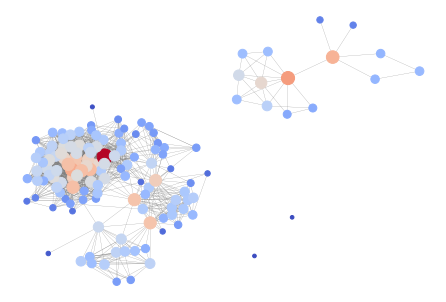

In [20]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
values = np.asarray(list(pr.values())) * 12000
low, *_, high = sorted(values)
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
nx.draw(G, pos, nodelist=ids, edge_color='grey', node_size=values, 
        node_color=[mapper.to_rgba(i) for i in values], 
        with_labels=False, width=0.2)
plt.savefig('pagerank.pdf')
plt.show()

In [21]:
top_pr_ids

['Alexander Grishutin',
 'Evgeny Buchnev',
 'Malik Gazizullin',
 'Nikita Smirnov',
 'Ilya Gridasov']

---
## Assortative Mixing

In [63]:
G.nodes

NodeView((1469093, 3656763, 5265607, 7153638, 7892706, 10119398, 11910268, 12609713, 12810131, 13404100, 13510576, 14533630, 16380545, 17733661, 17915197, 18102838, 18356489, 20212825, 22773958, 24026808, 24547797, 25727951, 26964810, 30076583, 31587016, 31728756, 33942442, 35848837, 36076214, 36526005, 36666259, 38995066, 39471311, 40048641, 40217702, 40824539, 43469037, 45141757, 47158694, 47515455, 49807565, 50066116, 51493561, 51746018, 53107550, 53847565, 54897324, 58497511, 59185093, 62715647, 63362507, 63784322, 65732473, 66146804, 66301589, 66721393, 66971472, 67522672, 71089350, 71353149, 71492241, 74233303, 74960828, 75014660, 75563326, 77305399, 79693569, 80384114, 81401088, 81894322, 81966467, 82278732, 82708218, 85352757, 86824543, 90937390, 92213949, 93047312, 95654500, 96598113, 96857977, 97241559, 97403068, 99029830, 99547525, 100370525, 100607102, 101822448, 106325788, 116559962, 117458567, 118004041, 118402672, 119012868, 119849578, 121058843, 123987640, 125476631, 13

In [68]:
G.nodes[1469093]['sex']

2

In [74]:
print('sex assortativity coefficient is %.2f' % nx.attribute_assortativity_coefficient(G, 'sex'))
print('city assortativity coefficient is %.2f' % nx.attribute_assortativity_coefficient(G, 'city'))
print('university assortativity coefficient is %.2f' % nx.attribute_assortativity_coefficient(G, 'university'))

sex assortativity coefficient is 0.04
city assortativity coefficient is 0.07
university assortativity coefficient is 0.18


In [22]:
color = []

for i in ids:
    if info[i]['city'] == 'Petrozavodsk' or info[i]['university'] == 'ПетрГУ':
        color.append('r')
    elif info[i]['city'] == 'Moscow' or info[i]['university'] == 'МФТИ (Физтех)':
        color.append('b')
    elif info[i]['city'] == 'Saint Petersburg':
        color.append('g')
    else:
        color.append('black')

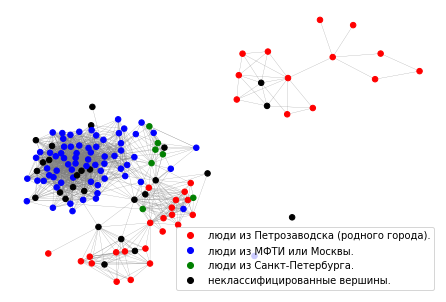

In [23]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw(G, pos, nodelist=ids, node_color=color, edge_color='grey', node_size=30, with_labels=False, width=0.2)

red = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
blue = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
green = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
black = mpl.lines.Line2D([0],[0], linestyle="none", c='black', marker = 'o')
    
plt.legend([red, blue, green, black], ['люди из Петрозаводска (родного города).', 'люди из МФТИ или Москвы.', 'люди из Санкт-Петербурга.', 'неклассифицированные вершины.'], numpoints = 1)
plt.savefig('assortative_mixing.pdf')
plt.show()

Легенда:

<span style="color:red"> *красные*</span> - люди из Петрозаводска (родного города).

<span style="color:blue"> *синие*</span> - люди из МФТИ или Москвы.

<span style="color:green"> *зеленые*</span> - люди из Санкт-Петербурга.

<span style="color:black"> *черные*</span> - неклассифицированные вершины.

---
## Node structural equivalence/similarity

##### equivavent nodes

In [24]:
adj_matrix = nx.adjacency_matrix(G).toarray()

In [25]:
for i, idx1 in enumerate(ids):
    for j, idx2 in enumerate(ids):
        if i <= j:
            continue
        a1 = adj_matrix[i]
        a2 = adj_matrix[j]
        a1[i] = 1
        a2[j] = 1
        if np.all(a1 == a2):
            print(names[idx1], names[idx2])

Galina Semyonova Denis Portyanko
Anton Korpusenko Nikolay Ermolin


---
Первая пара - дружат с 5 моими друзьями.

Вторая пара - дружат с 15 моими друзьями.

---
##### similar nodes

в качетстве расстояния взято косинусное расстояние

In [26]:
def plotDist(A):
    
    f, ax = plt.subplots(2, 2, figsize=(10,10))
    ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
    ax[0, 0].set_title('Adjacency Matrix')
    
    D = np.corrcoef(A)
    ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 0].set_title('Correlation coeff.')
    
    dVec = spt.distance.pdist(A, metric = 'euclidean')
    D = spt.distance.squareform(dVec)
    ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[0, 1].set_title('Euclidean Dist.')
    
    dVec = spt.distance.pdist(A, metric = 'cosine')
    D = spt.distance.squareform(dVec)
    ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
    ax[1, 1].set_title('Cosine Dist.')


/home/coder/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[:, None]
/home/coder/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/coder/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: divide by zero encountered in true_divide
  c /= stddev[None, :]
/home/coder/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


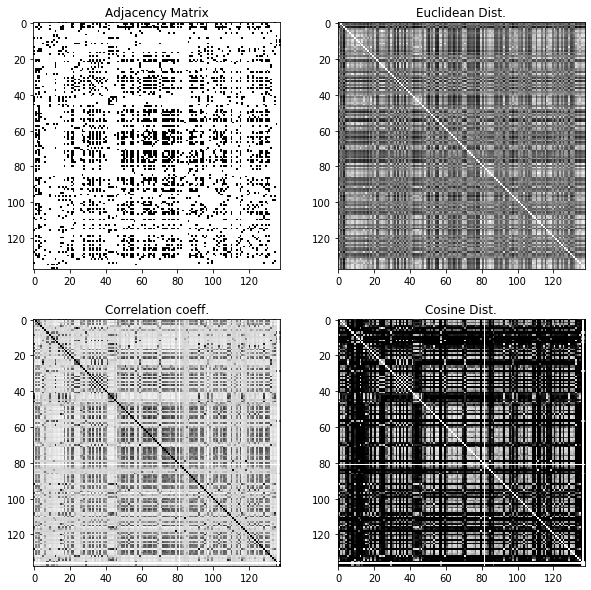

In [27]:
A = nx.to_numpy_matrix(G, dtype=int)
A = np.asarray(A)

plotDist(A)
plt.savefig('similarity.pdf')

In [28]:
sims = []

for i, idx1 in enumerate(ids):
    for j, idx2 in enumerate(ids):
        if i <= j:
            continue
        a1 = adj_matrix[i]
        a2 = adj_matrix[j]
        a1[i] = 1
        a2[j] = 1
        sims.append(((names[idx1], names[idx2], (a1 == a2).sum() / (a1.sum() ** 0.5 * a2.sum() ** 0.5))))

sims = sorted(sims, key=lambda x: -x[2])

In [29]:
sims[:9]

[('Dmitry Dmitrichenko', 'Andrey Grabovoy', 136.0),
 ('Andrey Grabovoy', 'Vlad Bulavas', 95.4594154601839),
 ('Andrey Grabovoy', 'Andrey Shvydko', 95.4594154601839),
 ('Yulia Myagkaya', 'Andrey Grabovoy', 95.4594154601839),
 ('Egor Kalmykov', 'Andrey Grabovoy', 95.4594154601839),
 ('Dmitry Dmitrichenko', 'Vlad Bulavas', 95.4594154601839),
 ('Dmitry Dmitrichenko', 'Andrey Shvydko', 95.4594154601839),
 ('Dmitry Dmitrichenko', 'Yulia Myagkaya', 95.4594154601839),
 ('Dmitry Dmitrichenko', 'Egor Kalmykov', 95.4594154601839)]

---
Ожидаемо, лидируют изолированные вершины (Dmitry Dmitrichenko и Andrey Grabovoy) с вершинами низкой степени.
В этом минус косинусного расстояния.

---
## Ther closest random graph model

Будем смотреть на правдопододие оценки, полученной методом максимального правдоподобия.

In [30]:
n = len(G)
m = len(G.edges())

degrees = np.asarray([max(1, degrees[i]) for i in range(n)])

In [32]:
# uniform
er_uniform_llh = round(sps.binom(n - 1, 0.5).logpmf(degrees).sum(), 2)

# binom
er_binom_lambda = np.arange(0.01, 100, 0.01)
er_binom_llh = []
for l in er_binom_lambda:
    er_binom_llh.append(sps.poisson(l, loc=0).logpmf(degrees).sum())
er_binom_llh = np.asarray(er_binom_llh)

er_binom_lambda = er_binom_lambda[er_binom_llh.argmax()]
er_binom_llh = round(er_binom_llh.max(), 2)

# preferential
C = 1 / (1 / (np.arange(1, n + 1, 1) ** 3)).sum()

ba_llh = round(np.log(C / (degrees ** 3)).sum(), 2)

In [33]:
print("Erdos-Renyi uniform model loglikelihood: {}".format(er_uniform_llh))
print("Erdos-Renyi binomial model loglikelihood: {}".format(er_binom_llh))
print("Preferential attachment model loglikelihood: {}".format(ba_llh))

Erdos-Renyi uniform model loglikelihood: -6004.14
Erdos-Renyi binomial model loglikelihood: -1195.32
Preferential attachment model loglikelihood: -1155.82


---
Биномиальная модель Эрдеша-Реньи и preferential attachment model дают примерно одинаковое правдоподобие.

---
# Community detection

## Clique search

In [34]:
max_clique_size = 0
cliques = []

for c in nx.find_cliques(G):
    cliques.append(c)

cliques = sorted(cliques, key=lambda x: -len(x))

In [35]:
max_clique = [names[c] for c in cliques[0]]

In [36]:
max_clique

['Yaroslav Chizh',
 'Malik Gazizullin',
 'Vyacheslav Ivanov',
 'Evgeny Gostkin',
 'Ilya Gridasov',
 'Anton Cherepkov',
 'Nikolay Pak',
 'Nikita Mikhaylov',
 'Igor Kuleshov',
 'Matvey Bezlepkin',
 'Valera Lobov',
 'Zaur Datkhuzhev',
 'Yury Skakovsky',
 'Nikita Protsenko',
 'Alexey Petrov',
 'Veronika Kalgushkina',
 'Dmitry Inyutin',
 'Konstantin Chernis']

In [37]:
len(max_clique)

18

In [38]:
clr = []

for i in ids:
    clr.append('red' if i in cliques[0] else 'blue')

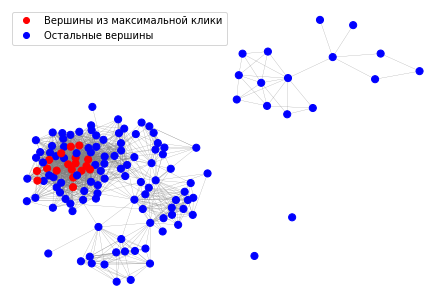

In [39]:
fig = plt.figure()
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")
nx.draw(G, pos, node_size=50, node_color=clr, edge_color='grey', with_labels=False, width=0.2)

red = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
blue = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
plt.legend([red, blue], ['Вершины из максимальной клики', 'Остальные вершины'], numpoints = 1)

plt.savefig('clique.pdf', dpi=plt.gcf().dpi)
plt.show()

----
## Comminutues

In [40]:
def MCL(A, tol, p, alpha):
    A[np.arange(A.shape[0]), np.arange(A.shape[0])] = 1
    step = 1
    col_sums = A.sum(axis = 0)
    T = A / col_sums
    M = T
    while(1):
        step += 1
        # Expancion step:
        
        M1 = np.linalg.matrix_power(M, p)
        # Inflation step:
        M1 = np.power(M1, alpha)
        col_sums = M1.sum(axis = 0)
        M1 = M1 / col_sums
        M1[M1<=tol] = 0
        if np.linalg.norm(M - M1) == 0:
            return M1
        else:
            M = M1.copy()

In [41]:
M = MCL(A, 0.005, 2, 1.5)

In [42]:
colors = ['red', 'blue', 'green', 'black', 'yellow', 'purple', 'orange']

clr = [None] * n

C = nx.Graph(M)
for i, c in enumerate(nx.connected_components(C)):
    c = list(c)
    for idx in c:
        clr[idx] = colors[i]

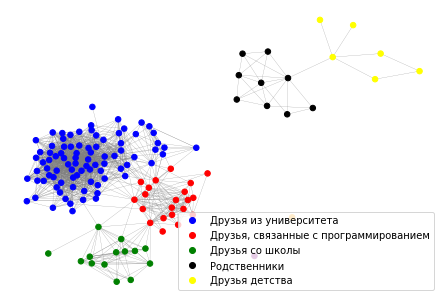

In [43]:
pos = nx.drawing.nx_agraph.graphviz_layout(G, prog="neato")

blue = mpl.lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
red = mpl.lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
green = mpl.lines.Line2D([0],[0], linestyle="none", c='g', marker = 'o')
black = mpl.lines.Line2D([0],[0], linestyle="none", c='black', marker = 'o')
yellow = mpl.lines.Line2D([0],[0], linestyle="none", c='yellow', marker = 'o')

nx.draw(G, pos, nodelist=ids, node_color=clr, edge_color='grey', node_size=30, with_labels=False, width=0.2)

plt.legend([blue, red, green, black, yellow], 
           ['Друзья из университета', 'Друзья, связанные с программированием', 'Друзья со школы', 
            'Родственники', 'Друзья детства'])
plt.savefig('clusters.pdf', dpi=plt.gcf().dpi)
plt.show()